# Install dependencies.

Pandas for Dataframes

PGMPY for Bayesian Network

In [ ]:
! pip install pandas;
! pip install pgmpy;

# Import dependencies

Import Pandas, Bayesian Network, Bayesian Estimator and VariableElimination

In [73]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete.CPD import TabularCPD

# Define Constants

Define constants for column names


In [80]:
Quali = "Qualifikation"
S = "Schnitt"
BL = "Bundesland"
M = "Mathe"
P = "Physik"
D = "Deutsch"
ST = "Schultyp"
OLTM = "OLT-Mathe"
OLTD = "OLT-Deutsch"
SFT = "Studierfähigkeitstest"
A = "Alter"
Geschl = "Geschlecht"
JEDE = "Jahreseinkommen der Eltern"
SB = "Staatsbürgerschaft"
SG = "Studiengang"
Absch= "Abschluss"

quali_data = ["Abitur", "Meister", "FH Reife", "Techniker"]
st_data = ["Allgemeinbildendes Gymnasium", "Wirtschaftsgymnasium", "Technisches Gymnasium"]
grade_data = ["Sehr Gut","Gut","Befriedigend", "Ausreichend", "mangelhaft"]
bl_data = ["Baden-Württemberg","Nordrhein-Westfalen","Bayern", "Sachsen", "Thüringen", "Bremen"]
olt_data = ["Sehr Gut", "Gut", "Schlecht"]
sft_data = ["Sehr Gut", "Gut", "Schlecht"]
age_data = ["Teen","YoungAdult","Adult"]
absch_data = ["gut", "bestanden", "abgebrochen"]
sg_data = ["Maschinenbau","Soziale Arbeit","Elektrotechnik", "Wirtschaftswissenschaften", "Informatik"]
sb_data = ["deutsch", "Non European", "EU Bürger"]
jede_data = ["Gering", "Mittel", "Hoch"]
g_data = ["m", "w"]

def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

# Load data and parse

Load data from "p001_1.csv" file and parse non-string variables

In [ ]:
init_data = pd.read_csv('p001_1.csv', sep=';',dtype={
    Quali: "string",
    S: "string",
    BL: "string",
    M: "string",
    P: "string",
    D: "string",
    ST: "string",
    OLTM: "string",
    OLTD: "string",
    SFT: "string",
    A: "string",
    Geschl: "string",
    JEDE: "string",
    SB: "string",
    SG: "string",
    Absch: "string"
})


def parse_df(data:pd.DataFrame):
    # Define data types for numerical columns
    numerical_columns = [S, M, D, P, OLTM, OLTD, SFT, A, JEDE]
    values = [S, M, D, P]

    if Absch in data:
        numerical_columns.append(Absch)
        values.append(Absch)

    #Change a Komma to a dot to convert values 
    for column in values:
        data[column] = data[column].str.replace(",",".")
    #Parse string to numeric(int or float)
    for column in numerical_columns:
        if column not in data:
            continue
        data.loc[:, column] = pd.to_numeric(
            data[column], errors="coerce"
        )
    
    # Handle missing values in categorical columns
    categorical_columns = [Quali, BL, ST, Geschl, SB, SG]
    for column in categorical_columns:
        # Replace missing values with the most frequent category
        data.loc[:, column].fillna(data[column].mode()[0], inplace=True)
    
    return data

init_data = parse_df(init_data)

display(init_data)

# Transform data 

Modify data to be more digestible and easily usable for the bayesian network

In [ ]:
#Map Abschlussnote to "abgebrochen", "gut" or "bestehen"
def map_absch(value):
    #If not a number "abgebrochen"
    if pd.isna(value):
        return("abgebrochen")
    #Range 1-2.4 is "gut"
    elif value < 2.5:
        return("gut")
    #Anything worse then 2.4 is "bestehen"
    else:
        return("bestehen")
                
#Map Age to "Teen", "YoungAdult" or "Adult"
def map_age(value):
    if pd.isna(value):
        return(value)
    elif  value < 20:
        return("Teen")
    elif  value < 25:
        return("YoungAdult")
    else:
        return("Adult")

#Map Grade to "Sehr Gut", "Gut" or "Befriedigend", "Ausreichend" or "mangelhaft"
def map_grade(value):
    if pd.isna(value):
        return(value)
    elif  value < 2:
        return("Sehr Gut")
    elif  value < 3:
        return("Gut")
    elif  value < 4:
        return("Befriedigend")
    elif  value == 4:
        return("Ausreichend")
    else:
        return("mangelhaft")

#Map OLT-Values (Math or German) to "Sehr Gut", "Gut" or "Schlecht"
def map_olt(value):
    if pd.isna(value):
        return(value)
    elif  value < 50:
        return("Schlecht")
    elif  value < 75:
        return("Gut")
    else:
        return("Sehr Gut")

#Map Studienfähigkeitstest to "Sehr Gut", "Gut" or "Schlecht"
def map_sft(value):
    if pd.isna(value):
        return(value)
    elif  value < 500:
        return("Schlecht")
    elif  value < 750:
        return("Gut")
    else:
        return("Sehr Gut")

#Map JahreseinkommenderEltern to "Gering", "Mittel" or "Hoch"
def map_jede(value):
    if pd.isna(value):
        return(value)
    elif value < 60000:
        return("Gering")
    elif value < 100000:
        return("Mittel")
    else: 
        return("Hoch")

#Function to Transform all relevant Data in Dataframe to understandable String value
def transform_data(data:pd.DataFrame):
    if Absch in data:
        new_absch = []
        for value in data[Absch]:
            new_absch.append(map_absch(value))
        data[Absch] = new_absch

    if A in data:
        new_age = []
        for value in data[A]:
            new_age.append(map_age(value))
        data[A] = new_age

    grades = [M, D, P, S]

    for grade in grades:
        if grade not in data:
            continue
        new_grade = []
        for value in data[grade]:
            new_grade.append(map_grade(value))
        data[grade] = new_grade

    if OLTD in data:
        new_oltd = []
        for value in data[OLTD]:
            new_oltd.append(map_olt(value))
        data[OLTD] = new_oltd

    if OLTM in data:
        new_oltm = []
        for value in data[OLTM]:
            new_oltm.append(map_olt(value))
        data[OLTM] = new_oltm

    if SFT in data:
        new_sft = []
        for value in data[SFT]:
            new_sft.append(map_sft(value))
        data[SFT] = new_sft

    if JEDE in data:
        new_jede = []
        for value in data[JEDE]:
            new_jede.append(map_jede(value))
        data[JEDE] = new_jede

    return data

init_data = transform_data(init_data)

display(init_data)

# Define CPDs for Bayesian Network

Define CPDs for the Bayesian Network using default values and assumptions

In [82]:
bl_cpd = TabularCPD(BL, 6, [[1/6], [1/6], [1/6], [1/6], [1/6], [1/6]], state_names={BL: bl_data})
st_cpd = TabularCPD(ST, 3, [[1/3],[1/3],[1/3]], state_names={ST:st_data})
jede_cpd = TabularCPD(JEDE, 3, [[1/3, 1/3, 1/3, 1/3, 1/3, 1/3],
                                [1/3, 1/3, 1/3, 1/3, 1/3, 1/3],
                                [1/3, 1/3, 1/3, 1/3, 1/3, 1/3]],
                                state_names={JEDE:jede_data, BL:bl_data}, evidence=[BL], evidence_card=[6])
sg_cpd = TabularCPD(SG, 5, [[1/5,1/5,1/5,1/5,1/5,1/5,1/5,1/5,1/5],
                            [1/5,1/5,1/5,1/5,1/5,1/5,1/5,1/5,1/5],
                            [1/5,1/5,1/5,1/5,1/5,1/5,1/5,1/5,1/5],
                            [1/5,1/5,1/5,1/5,1/5,1/5,1/5,1/5,1/5],
                            [1/5,1/5,1/5,1/5,1/5,1/5,1/5,1/5,1/5]],
                            state_names={SG:sg_data, ST:st_data, JEDE:jede_data}, evidence=[ST, JEDE], evidence_card=[3, 3])
quali_cpd = TabularCPD(Quali, 4, [[1/4],[1/4],[1/4],[1/4]], state_names={Quali:quali_data})
s_cpd = TabularCPD(S, 5, [[1/5, 1/5, 1/5, 1/5],
                          [1/5, 1/5, 1/5, 1/5],
                          [1/5, 1/5, 1/5, 1/5],
                          [1/5, 1/5, 1/5, 1/5],
                          [1/5, 1/5, 1/5, 1/5]],
                          state_names={S:grade_data, Quali:quali_data}, evidence=[Quali], evidence_card=[4])
m_cpd = TabularCPD(M, 5, [[1/2, 1/4, 1/8, 1/8, 0],
                          [1/4, 1/4, 1/4, 1/8, 1/8],
                          [1/8, 1/4, 1/4, 1/4, 1/8],
                          [1/8, 1/8, 1/4, 1/4, 1/4],
                          [0, 1/8, 1/8, 1/4, 1/2]],
                          state_names={S:grade_data, M:grade_data}, evidence=[S], evidence_card=[5])
p_cpd = TabularCPD(P, 5, [[1/2, 1/4, 1/8, 1/8, 0],
                          [1/4, 1/4, 1/4, 1/8, 1/8],
                          [1/8, 1/4, 1/4, 1/4, 1/8],
                          [1/8, 1/8, 1/4, 1/4, 1/4],
                          [0, 1/8, 1/8, 1/4, 1/2]],
                          state_names={S:grade_data, P:grade_data}, evidence=[5], evidence_card=[5])
d_cpd = TabularCPD(D, 5, [[1/2, 1/4, 1/8, 1/8, 0],
                          [1/4, 1/4, 1/4, 1/8, 1/8],
                          [1/8, 1/4, 1/4, 1/4, 1/8],
                          [1/8, 1/8, 1/4, 1/4, 1/4],
                          [0, 1/8, 1/8, 1/4, 1/2]],
                          state_names={S:grade_data, D:grade_data}, evidence=[S], evidence_card=[5])
oltm_cpd = TabularCPD(OLTM, 3, [[ 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3],
                            [ 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3],
                            [ 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3]],
                            state_names={OLTM:olt_data, M:grade_data, P:grade_data}, evidence={M, P}, evidence_card=[5, 5])
oltd_cpd = TabularCPD(OLTD, 3, [[ 3/4, 1/2, 1/4, 1/8, 0],
                            [ 1/4, 3/8, 1/2, 3/8, 1/4],
                            [ 0, 1/8, 1/4, 1/2, 3/4]],
                            state_names={OLTD:olt_data, D:grade_data}, evidence={D}, evidence_card=[5])
a_cpd = TabularCPD(A, 3, [[1/3], [1/3], [1/3]], state_names={A: age_data})
sb_cpd = TabularCPD(SB, 3, [[1/3], [1/3], [1/3]], state_names={SB: sb_data})
g_cpd = TabularCPD(Geschl, 2, [[1/2], [1/2]], state_names={Geschl: g_data})

#SFT und Abschl fehlt noch, ist aber viel zu groß bin nicht sicher ob das gut ist

print_full(g_cpd)

+---------------+-----+
| Geschlecht(m) | 0.5 |
+---------------+-----+
| Geschlecht(w) | 0.5 |
+---------------+-----+


# Create Bayesian Network

Create Bayesian Network with nodes and edges and fitting it with the data from the csv

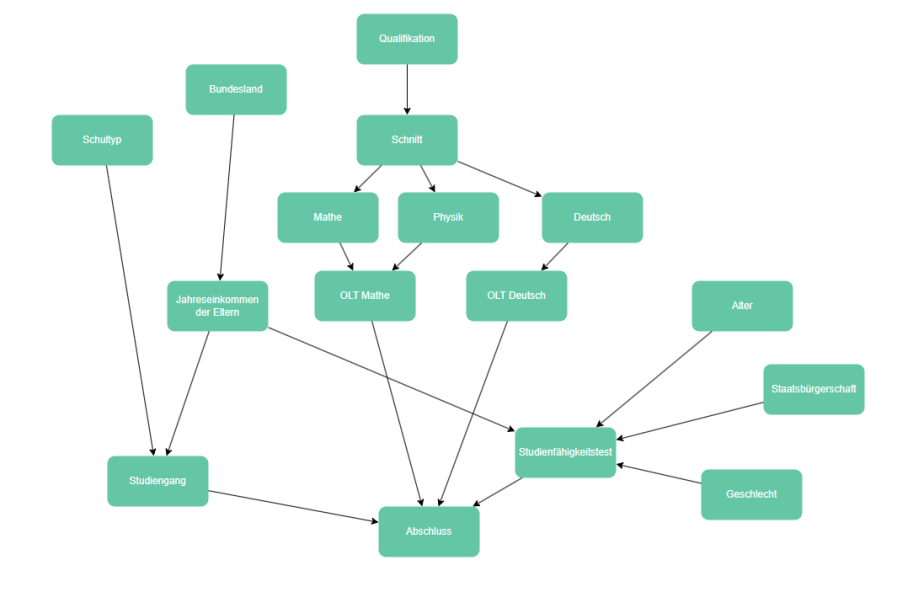

In [84]:
# Create Bayesian Network
G = BayesianNetwork()
G.add_nodes_from(init_data.columns)
display(init_data)

# Add edges to the network
G.add_edges_from([
    (ST, SG),  # Schultyp → Studiengang
    (Quali, S),  # Qualifikation → Schnitt
    (S, M),  # Schnitt → Mathe
    (S, D),  # Schnitt → Deutsch
    (S, P),  # Schnitt → Physik
    (P, OLTM),  # Physik → OLT-Mathe
    (M, OLTM),  # Mathe → OLT-Mathe
    (D, OLTD),  # Deutsch → OLT-Deutsch
    (OLTM, Absch),  # OLT-Mathe → Abschluss
    (OLTD, Absch),  # OLT-Deutsch → Abschluss
    (BL, JEDE),  # Bundesland → Jahreseinkommen der Eltern
    (JEDE, SFT),  # Jahreseinkommen der Eltern → Studierfähigkeitstest
    (JEDE, SG),  # Jahreseinkommen der Eltern → Studiengang
    (SG, Absch),  # Studiengang → Abschluss
    (A, SFT),  # Alter → Studierfähigkeitstest
    (Geschl, SFT),  # Geschlecht → Studierfähigkeitstest
    (SB, SFT), # Staatsbürgerschaft → Studierfähigkeitstest,
    (SFT, Absch) # Studierfähigkeitstest -> Abschluss
])

# Use BayesianEstimator to learn the CPDs
G.fit(data=init_data, estimator=BayesianEstimator)
for cpd in G.get_cpds():
    print_full(cpd)

,Qualifikation,Schnitt,Bundesland,Mathe,Physik,Deutsch,Schultyp,OLT-Mathe,OLT-Deutsch,Studierfähigkeitstest,Alter,Geschlecht,Jahreseinkommen der Eltern,Staatsbürgerschaft,Studiengang,Abschluss
0,Abitur,Gut,Baden-Württemberg,Gut,Gut,Gut,Allgemeinbildendes Gymnasium,Gut,Gut,Gut,Teen,m,Gering,deutsch,Maschinenbau,bestehen
1,Meister,Sehr Gut,Nordrhein-Westfalen,<NA>,<NA>,<NA>,n.a.,Schlecht,Gut,<NA>,Adult,m,Mittel,deutsch,Maschinenbau,abgebrochen
2,Abitur,Sehr Gut,Baden-Württemberg,Sehr Gut,Sehr Gut,Sehr Gut,Wirtschaftsgymnasium,Sehr Gut,Sehr Gut,<NA>,Teen,w,Hoch,deutsch,Soziale Arbeit,gut
3,Abitur,Sehr Gut,Baden-Württemberg,Gut,Gut,Sehr Gut,Technisches Gymnasium,Gut,Sehr Gut,<NA>,Teen,m,Hoch,deutsch,Elektrotechnik,bestehen
4,Abitur,Sehr Gut,Bayern,Gut,Gut,Sehr Gut,Wirtschaftsgymnasium,Gut,Sehr Gut,<NA>,Teen,m,Mittel,deutsch,Elektrotechnik,gut
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Abitur,Sehr Gut,Baden-Württemberg,Gut,Gut,Gut,Allgemeinbildendes Gymnasium,Gut,Gut,NaN,Teen,w,Hoch,deutsch,Elektrotechnik,bestehen
96,Abitur,Gut,Baden-Württemberg,Sehr Gut,Sehr Gut,Sehr Gut,Technisches Gymnasium,Sehr Gut,Sehr Gut,NaN,YoungAdult,m,Mittel,deutsch,Wirtschaftswissenschaften,gut
97,Abitur,Sehr Gut,Baden-Württemberg,Gut,Gut,Sehr Gut,Technisches Gymnasium,Sehr Gut,Sehr Gut,NaN,Teen,m,Hoch,deutsch,Maschinenbau,gut
98,Abitur,Gut,Bayern,Sehr Gut,Sehr Gut,Sehr Gut,Allgemeinbildendes Gymnasium,Sehr Gut,Sehr Gut,NaN,Teen,m,Hoch,deutsch,Maschinenbau,gut


+--------------------------+---------+
| Qualifikation(Abitur)    | 0.53125 |
+--------------------------+---------+
| Qualifikation(FH Reife)  | 0.15625 |
+--------------------------+---------+
| Qualifikation(Meister)   | 0.15625 |
+--------------------------+---------+
| Qualifikation(Techniker) | 0.15625 |
+--------------------------+---------+
+-----------------------+-----------------------+-------------------------+------------------------+--------------------------+
| Qualifikation         | Qualifikation(Abitur) | Qualifikation(FH Reife) | Qualifikation(Meister) | Qualifikation(Techniker) |
+-----------------------+-----------------------+-------------------------+------------------------+--------------------------+
| Schnitt(Befriedigend) | 0.09803921568627451   | 0.33333333333333337     | 0.33333333333333337    | 0.33333333333333337      |
+-----------------------+-----------------------+-------------------------+------------------------+--------------------------+
| Schnitt

# Test prediction

Makes a test prediction to verify the Bayesian Network

In [ ]:
# Perform inference with incomplete input
# Example: Predict Abschluss for a student with Qualifikation = "Abitur",
# Schultyp = "Allgemeinbildendes Gymnasium", BL = "Baden-Württemberg",
# and A = 22
evidence = {
    Quali: "Abitur",
    ST: "Allgemeinbildendes Gymnasium",
    BL: "Baden-Württemberg",
    A: "Adult"
}

# Use Variable Elimination to make predictions
infer = VariableElimination(G)
print(evidence)
q = infer.query(variables=[Absch], evidence=evidence)
print(q)

# Test

Loads "test.csv" and runs a prediction using the created model

In [ ]:
#Load data from "test.csv" 
test_data = pd.read_csv('test.csv', sep=';',dtype=str)

#Set empty Colums to NA
for column in test_data.columns:
    if test_data[column][0] == "":
        test_data[column][0] = pd.NA

#Parse and transform raw data
test_data = parse_df(test_data)
test_data = transform_data(test_data)

#Remove NA Columns
for column in test_data.columns:
    if pd.isna(test_data[column][0]):
        test_data = test_data.drop(columns=column)

# Use Variable Elimination to make prediction
infer = VariableElimination(G)
q = infer.query(variables=[Absch], evidence=test_data.to_dict(orient='records')[0])
print(q)